In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot
from time import perf_counter

Number of train samples: 60000
Number of test samples: 10000


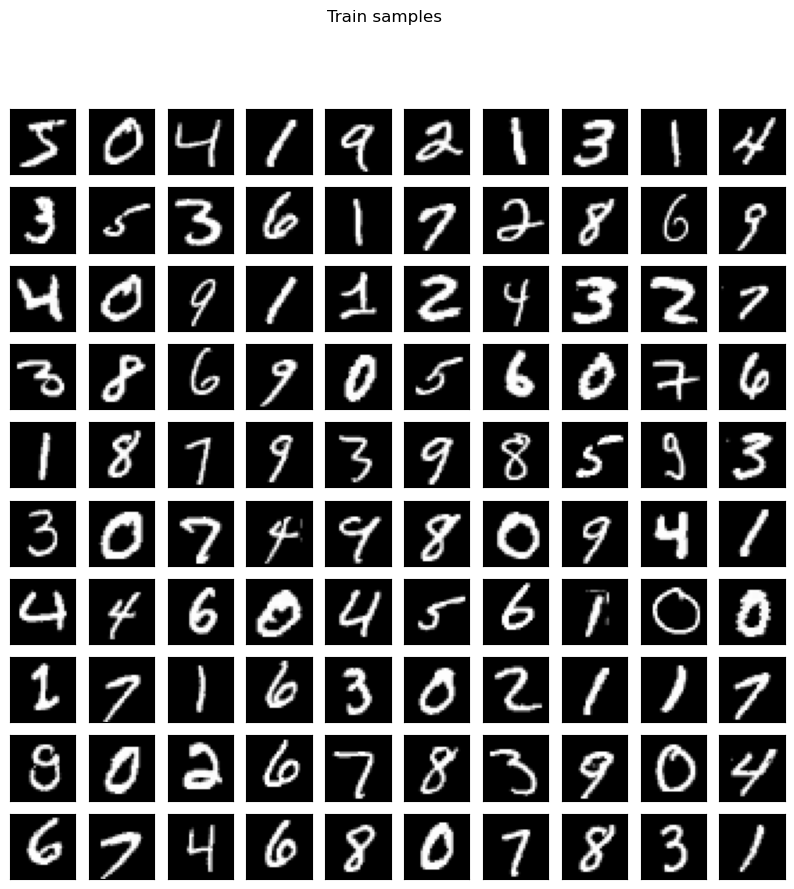

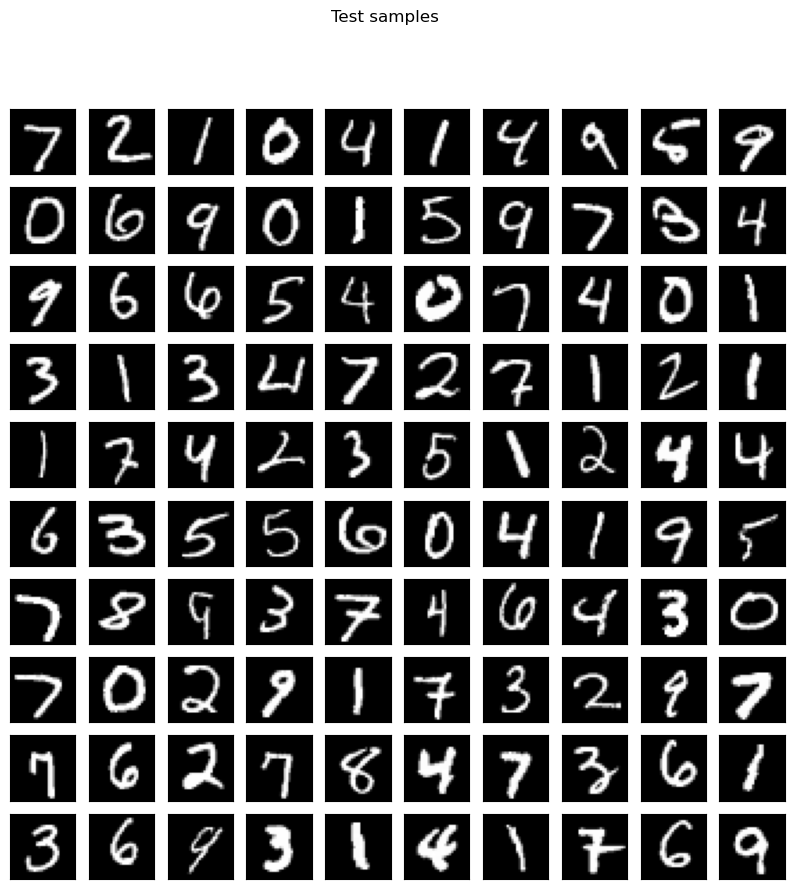

In [3]:
dir_name = os.getcwd() # текущая директория
batch_size = 64 # размер пачки
image_resolution = 28 * 28 # число нейронов на входе
num_classes = 10 # число нейронов на выходе
hidden_dim = 300 # число нейронов в скрытом слое
learning_rate = 0.1 # скорость обучения 
num_epochs = 20 # число эпох

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (num_showed_imgs_x, num_showed_imgs_y)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.imshow(img, cmap = 'gray')

# Чтение тренировочной и тестовой выборок набора данных MNIST
train_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

# Создание объектов для последовательной загрузки пачек из тренировочной и тестовой выборок
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [4]:
class LogisticRegressionModel(torch.nn.Module):
    # конструктор
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        
        # создание одного полносвязного слоя
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        # функция активации
        self.relu = torch.nn.ReLU()
        # создание второго полносвязного слоя
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
    
    # переопределение метода, вызываемого в процессе прямого прохода
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

# создание объекта разработанного класса
logreg_nn = LogisticRegressionModel(image_resolution, hidden_dim, num_classes)

In [5]:
# выбор устройства
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logreg_nn.to(device)

# функция ошибки
loss_function = torch.nn.CrossEntropyLoss()
# метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(logreg_nn.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.reshape(-1, image_resolution)
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return tp / n

def relu(x):
    return torch.mul(x, x > 0)

def softmax(x):
    return torch.softmax(x, 1)

In [39]:
for epoch in range(num_epochs): # проход по заданным эпохам
    time = perf_counter()
    for i, (images, labels) in enumerate(train_data_loader):
        # преобразование тензора [B, C, W, H] к формату [B, W * H]
        # images.shape = [B, C, W, H], B - размер пачки,
        # C - число каналов, W - ширина, H - высота (С = 1)!
        # и отправка данных на устройство
        images = images.view(-1, image_resolution).requires_grad_().to(device)
        labels = labels.to(device)

        # прямой проход
        # вычисление выхода сети
        outputs = logreg_nn(images)
        # вычисление ошибки
        loss = loss_function(outputs, labels)

        # обратный проход
        # обнуление всех вычисляемых градиентов и вычисление градиента фукнции ошибки
        optimizer.zero_grad()
        loss.backward()
         # обновление параметров модели
        optimizer.step()
    time = perf_counter() - time
    # точность для каждой эпохе на тренировочном наборе данных
    print('Epoch[{}]: accuracy = {}'.
          format(epoch, get_accuracy(train_data_loader, logreg_nn)), "time = ", time)
# точность на тестовой выборке
print("Тестовая точность = " + str(get_accuracy(test_data_loader, logreg_nn)))

Epoch[0]: accuracy = 0.9277166724205017 time =  14.12884160000067
Epoch[1]: accuracy = 0.9501333236694336 time =  15.826455200000055
Epoch[2]: accuracy = 0.9610333442687988 time =  14.055838799999947
Epoch[3]: accuracy = 0.9683499932289124 time =  14.211121700000149
Epoch[4]: accuracy = 0.97243332862854 time =  14.256590899999537
Epoch[5]: accuracy = 0.9790666699409485 time =  13.919072500000766
Epoch[6]: accuracy = 0.9819333553314209 time =  14.000681600000462
Epoch[7]: accuracy = 0.9834666848182678 time =  13.957633300000452
Epoch[8]: accuracy = 0.9856166839599609 time =  14.196970599999986
Epoch[9]: accuracy = 0.987416684627533 time =  14.046000600000298
Epoch[10]: accuracy = 0.989216685295105 time =  14.326960599999438
Epoch[11]: accuracy = 0.9915000200271606 time =  14.283991500000411
Epoch[12]: accuracy = 0.9922999739646912 time =  14.088973099999748
Epoch[13]: accuracy = 0.9924166798591614 time =  14.431427600000461
Epoch[14]: accuracy = 0.9940500259399414 time =  15.77840330000

In [6]:
class Model:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.inputDim = input_dim
        self.hiddenDim = hidden_dim
        self.outputDim = output_dim
        self.initialize_weights()
    def initialize_weights(self):
        self.w1 = torch.zeros(( self.hiddenDim, self.inputDim ))
        self.w2 = torch.zeros(( self.outputDim, self.hiddenDim))
        self.b1 = torch.zeros(( self.hiddenDim, 1))
        self.b2 = torch.zeros((self.outputDim, 1))
        torch.nn.init.xavier_normal_(self.w1)
        torch.nn.init.xavier_normal_(self.w2)
        return
    def forward(self, imgs):
        self.z1 = imgs@self.w1.transpose(0,1) + self.b1.transpose(0,1)
        self.rz1 = relu(self.z1)
        self.z2 = self.rz1@self.w2.transpose(0,1) + self.b2.transpose(0,1)
        self.sz2 = softmax(self.z2)
        self.input = imgs
        return self.sz2
    def backward(self, labels):        
        new_labels = torch.zeros_like(self.sz2)
        for i in range(labels.shape[0]):
            new_labels[i, labels[i]] = 1 # Iindicator(y(k)==k)!
        # get deltas
        delta_t = (self.sz2 - new_labels) / labels.shape[0]
        delta_w = torch.mul(delta_t @ self.w2, self.z1 > 0)
        # calc derivatives and make step
        self.w1 -= learning_rate * ( delta_w.transpose(0, 1) @ self.input ) # * dw1
        self.w2 -= learning_rate * ( delta_t.transpose(0, 1) @ self.rz1 ) # * dw2
        self.b1 -= learning_rate * delta_w.sum(0).unsqueeze(-1)
        self.b2 -= learning_rate * delta_t.sum(0).unsqueeze(-1)
        return
    def __call__(self, images):
        return self.forward(images)


In [7]:
mm = Model(image_resolution,300, 10)

for epoch in range(num_epochs):
    etime = perf_counter()
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.view(-1, image_resolution).requires_grad_().to(device)
        labels = labels.to(device)
        mm.forward(images)
        mm.backward(labels)
    etime = perf_counter() - etime
    accuracy = get_accuracy(train_data_loader, mm)
    print('Epoch[{}]: accuracy = {}'.
          format(epoch, get_accuracy(train_data_loader, mm)), "time = ", etime)


Epoch[0]: accuracy = 0.934499979019165 time =  15.737419900000532
Epoch[1]: accuracy = 0.9575666785240173 time =  14.491828000000169
Epoch[2]: accuracy = 0.9663500189781189 time =  14.916060599998673
Epoch[3]: accuracy = 0.9737333059310913 time =  14.804421799999545
Epoch[4]: accuracy = 0.9778833389282227 time =  14.883993999999802
Epoch[5]: accuracy = 0.9819666743278503 time =  15.158874300001116
Epoch[6]: accuracy = 0.9851499795913696 time =  14.961033400000815
Epoch[7]: accuracy = 0.9866166710853577 time =  14.915756700000202
Epoch[8]: accuracy = 0.9882333278656006 time =  15.44569859999865
Epoch[9]: accuracy = 0.9890999794006348 time =  14.990329700000075
Epoch[10]: accuracy = 0.9891833066940308 time =  15.0934572999995
Epoch[11]: accuracy = 0.9928500056266785 time =  15.057882099999915
Epoch[12]: accuracy = 0.9933833479881287 time =  15.211063900000227
Epoch[13]: accuracy = 0.9940166473388672 time =  15.867777899999055
Epoch[14]: accuracy = 0.9951833486557007 time =  16.6362697000

In [8]:
accuracy = get_accuracy(test_data_loader, mm)
print("Точность на тестовой выборке: " + str(accuracy))

Точность на тестовой выборке: tensor(0.9807)
